<a href="https://colab.research.google.com/github/Shariar076/notebook-snapshots/blob/main/Transformers_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

This is yet another implementation of transformers from screatch, following [this](https://https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb) tutorial.


Let’s start by importing the necessary libraries and modules.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy


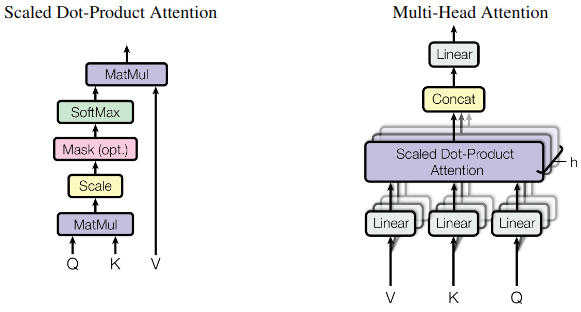

# The Multi-Head Attention
The Multi-Head Attention mechanism computes the attention between each pair of positions in a sequence. It consists of multiple “attention heads” that capture different aspects of the input sequence.

The MultiHeadAttention code initializes the module with input parameters and linear transformation layers. It calculates attention scores, reshapes the input tensor into multiple heads, and combines the attention outputs from all heads. The forward method computes the multi-head self-attention, allowing the model to focus on some different aspects of the input sequence.

$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

# Position-wise Feed-Forward Networks
The PositionWiseFeedForward class extends PyTorch’s nn.Module and implements a position-wise feed-forward network. The class initializes with two linear transformation layers and a ReLU activation function. The forward method applies these transformations and activation function sequentially to compute the output. This process enables the model to consider the position of input elements while making predictions.

$$FFN(x) = max(0, xW_1 + b1 )W_2 + b2
 $$

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# Positional Encoding
Positional Encoding is used to inject the position information of each token in the input sequence. It uses sine and cosine functions of different frequencies to generate the positional encoding.

$$ PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}} ) $$
$$ PE_{(pos,2{i+1})} = cos(pos/10000^{2i/d_{model}} ) $$

The PositionalEncoding class initializes with input parameters d_model and max_seq_length, creating a tensor to store positional encoding values. The class calculates sine and cosine values for even and odd indices, respectively, based on the scaling factor div_term. The forward method computes the positional encoding by adding the stored positional encoding values to the input tensor, allowing the model to capture the position information of the input sequence.


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


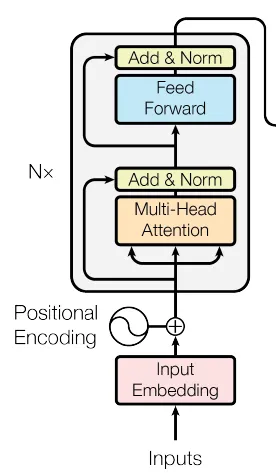

# Encoder Layer
An Encoder layer consists of a Multi-Head Attention layer, a Position-wise Feed-Forward layer, and two Layer Normalization layers.

The EncoderLayer class initializes with input parameters and components, including a MultiHeadAttention module, a PositionWiseFeedForward module, two layer normalization modules, and a dropout layer. The forward methods computes the encoder layer output by applying self-attention, adding the attention output to the input tensor, and normalizing the result. Then, it computes the position-wise feed-forward output, combines it with the normalized self-attention output, and normalizes the final result before returning the processed tensor.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


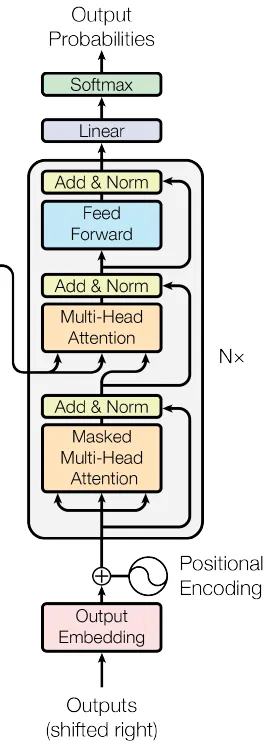

# Decoder Layer
A Decoder layer consists of two Multi-Head Attention layers, a Position-wise Feed-Forward layer, and three Layer Normalization layers.

The DecoderLayer initializes with input parameters and components such as MultiHeadAttention modules for masked self-attention and cross-attention, a PositionWiseFeedForward module, three layer normalization modules, and a dropout layer.

The forward method computes the decoder layer output by performing the following steps:

1. Calculate the masked self-attention output and add it to the input tensor, followed by dropout and layer normalization.
2. Compute the cross-attention output between the decoder and encoder outputs, and add it to the normalized masked self-attention output, followed by dropout and layer normalization.
3. Calculate the position-wise feed-forward output and combine it with the normalized cross-attention output, followed by dropout and layer normalization.
4. Return the processed tensor.

These operations enable the decoder to generate target sequences based on the input and the encoder output.

Now, let’s combine the Encoder and Decoder layers to create the complete Transformer model.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


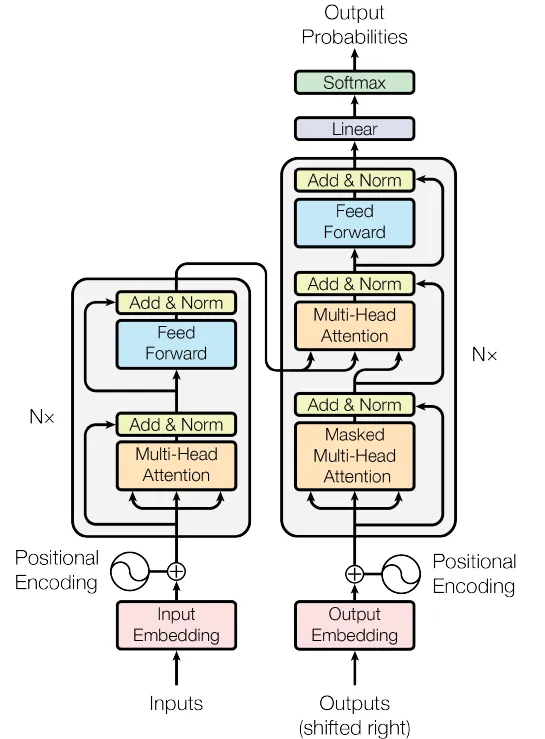

# Transformer Model
Merging it all together:

The Transformer class combines the previously defined modules to create a complete Transformer model. During initialization, the Transformer module sets up input parameters and initializes various components, including embedding layers for source and target sequences, a PositionalEncoding module, EncoderLayer and DecoderLayer modules to create stacked layers, a linear layer for projecting decoder output, and a dropout layer.

The generate_mask method creates binary masks for source and target sequences to ignore padding tokens and prevent the decoder from attending to future tokens. The forward method computes the Transformer model’s output through the following steps:

1. Generate source and target masks using the generate_mask method.
2. Compute source and target embeddings, and apply positional encoding and dropout.
3. Process the source sequence through encoder layers, updating the enc_output tensor.
4. Process the target sequence through decoder layers, using enc_output and masks, and updating the dec_output tensor.
5. Apply the linear projection layer to the decoder output, obtaining output logits.

These steps enable the Transformer model to process input sequences and generate output sequences based on the combined functionality of its components.



In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

# Preparing Sample Data
In this example, we will create a toy dataset for demonstration purposes. In practice, you would use a larger dataset, preprocess the text, and create vocabulary mappings for source and target languages.

In [ ]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

# Training the Model
Now we’ll train the model using the sample data. In practice, you would use a larger dataset and split it into training and validation sets.

We can use this way to build a simple Transformer from scratch in Pytorch. All Large Language Models use these Transformer encoder or decoder blocks for training. Hence understanding the network that started it all is extremely important. Hope this article helps all looking to deep dive into LLM’s.



In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.670969009399414
Epoch: 2, Loss: 8.537796974182129
Epoch: 3, Loss: 8.467591285705566
Epoch: 4, Loss: 8.414406776428223
Epoch: 5, Loss: 8.356472969055176
Epoch: 6, Loss: 8.281331062316895
Epoch: 7, Loss: 8.191354751586914
Epoch: 8, Loss: 8.114676475524902
Epoch: 9, Loss: 8.02998161315918
Epoch: 10, Loss: 7.948646068572998
Epoch: 11, Loss: 7.865720272064209
Epoch: 12, Loss: 7.782844543457031
Epoch: 13, Loss: 7.69953727722168
Epoch: 14, Loss: 7.620488166809082
Epoch: 15, Loss: 7.5320258140563965
Epoch: 16, Loss: 7.4514617919921875
Epoch: 17, Loss: 7.369067668914795
Epoch: 18, Loss: 7.279372692108154
Epoch: 19, Loss: 7.202409267425537
Epoch: 20, Loss: 7.124303340911865
Epoch: 21, Loss: 7.048576354980469
Epoch: 22, Loss: 6.965213775634766
Epoch: 23, Loss: 6.887179851531982
Epoch: 24, Loss: 6.810876846313477
Epoch: 25, Loss: 6.737051963806152
Epoch: 26, Loss: 6.659013271331787
Epoch: 27, Loss: 6.586770534515381
Epoch: 28, Loss: 6.5220794677734375
Epoch: 29, Loss: 6.447156906